### Heavy Cleaning of Tweet Data with BERT

Here, we test cleaning up our text data more heavily. We remove stopwords, punctuation, and other aspects of Tweets that might add too much noise to our model. We also lemmatize and stem our text.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import feature_extraction, preprocessing, linear_model, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from pandas_profiling import ProfileReport
import scikitplot as skplt
import string
import random
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert
import sys
import os
sys.path.append('../utility')
import utils

# seaborn settings
sns.set_theme(style="whitegrid")
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# download pickles
train_df = pd.read_pickle("../data/pickles/clean_train_data.pkl")
test_df = pd.read_pickle("../data/pickles/clean_test_data.pkl")

### Heavy Text Cleaning

We clean up the text a lot here.

In [3]:
# function taken and modified 
# from https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76

stopwords = set(STOPWORDS)
stopwords.update(["nan"])

def heavy_text_clean(x):
    # first we lowercase everything
    x = x.lower()
    x = ' '.join([word for word in x.split(' ') if word not in stopwords])
    # remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'http*\S+', ' ', x)
    # then use regex to remove @ symbols and hashtags
    x = re.sub(r'@\S', '', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
    return x

In [4]:
train_df['cleaned_text'] = train_df.text.apply(heavy_text_clean)
test_df['cleaned_text'] = test_df.text.apply(heavy_text_clean)

In [5]:
list(train_df['cleaned_text'].sample(20))

['look sports riots google see couches burned fr gotta go ',
 'night blew rq',
 'disaster averted police kill gunman device cinema ',
 'hurricane mixxtail kinda tastes watermelon four loko ',
 'irafrog ount wario wrecked again ',
 ' withering death album found undermine backyard cat inundated floor mustering cat food ',
 'big baby climbed thing wheels io hawk his knee injury belt mr srk cook ur beautiful ass punishment ',
 'mourning notices stabbing arson victims stir politics grief israel ',
 'family mourns drowning toddler rare epilepsy bradley diebold suffered hundreds epileptic ',
 'razyindapeg completely understandable considering trauma ',
 ' london warship exploded sailors recycling artillery cartridges ',
 'punjab government flood relief platform realtime information inundation damages rescue efforts amp travel alerts',
 'white people know worry tirelessly black black crime going mass murderer problem ',
 'guy whistled parking lot amp help wind blew skirt getting car ',
 'sever

**Separating text and non-text columns:**

In [6]:
# create final dfs without text col
final_train_df = train_df.drop(columns=['text', 'id'])
final_test_df = test_df.drop(columns=['text', 'id'])

In [7]:
# save labels
train_labels = final_train_df['target']

In [8]:
# separate clean text
train_text = final_train_df['cleaned_text']
test_text = final_test_df['cleaned_text']

### Lemmatization

This returns the lemma of the words in the Tweets, in other words, the base. So, for example, "runs" and "running" simply become "run". This can sometimes help a model interpret sentences better, so we test it here.

In [9]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexanderbricken/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbricken/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
train_list = []
for word in train_text:
    tokens = word_tokenize(word)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    train_list.append(' '.join(lemmatized))

test_list = []
for word in test_text:
    tokens = word_tokenize(word)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    test_list.append(' '.join(lemmatized))

### Tokenization

I perform tokenization here as a basic way of including the data of my text into the machine learning model.

Tokenization separates a piece of text into tokens. These tokens are words. It allows the text data to be turned into numbers that the machine learning model can read.

**For `cleaned_text` column, we tokenise using BertTokenizer:**

In [11]:
# we use a pre-trained bert model to tokenize the text
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

To start with, because BERT works with fixed-length sequences, we need to choose the maximum length of the sequences to best represent the model. By storing the length of each Tweet, we can do this and evaluate the coverage.

In [12]:
token_lens = []
for txt in list(train_list):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

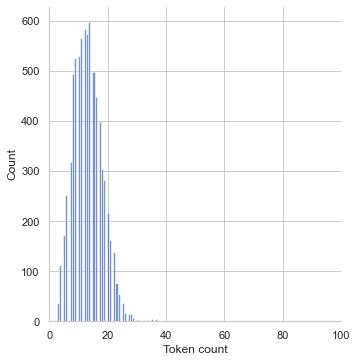

In [13]:
sns.displot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')
plt.show()

From this plot, we see the density drops off beyond 40. We set max_length to 40.

In [14]:
def bert_tokenizer(text):
    encoding = tokenizer.encode_plus(
    text,
    max_length=40,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids'][0], encoding['attention_mask'][0]

In [15]:
max_length=40
# train data tokenization
train_tokenized_list = []
train_attn_mask_list = []
for text in list(train_list):
    tokenized_text, attn_mask = bert_tokenizer(text)
    train_tokenized_list.append(tokenized_text.numpy())
    train_attn_mask_list.append(attn_mask.numpy())

In [16]:
# test data tokenization
test_tokenized_list = []
test_attn_mask_list = []
for text in list(test_list):
    tokenized_text, attn_mask = bert_tokenizer(text)
    test_tokenized_list.append(tokenized_text.numpy())
    test_attn_mask_list.append(attn_mask.numpy())

In [17]:
train_tokenised_text_df = pd.DataFrame(train_tokenized_list)
test_tokenised_text_df = pd.DataFrame(test_tokenized_list)

Train test split:

In [18]:
# train test split
X_train, X_test, y_train, y_test, train_mask, val_mask = train_test_split(train_tokenised_text_df, train_labels, train_attn_mask_list, test_size=0.3, random_state=42)

### BERT Modelling

In [19]:
num_classes = len(train_labels.unique())

I use the same pre-trained BERT model here. I also use 3 epochs to simulate some early stopping and prevent overfitting. I initially ran more epochs, but found 3 to be reasonable.

In [20]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

checkpoint_path = "../models/heavy_tf_bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

print('\nBert Model', bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [21]:
history=bert_model.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=3,
                       validation_data=(X_test, y_test),
                       callbacks=[model_callback])

Epoch 1/3
163/163 [==============================] - 1150s 7s/step - loss: 0.5629 - accuracy: 0.7216 - val_loss: 0.4426 - val_accuracy: 0.8045

Epoch 00001: saving model to ../models/heavy_tf_bert.ckpt
Epoch 2/3
163/163 [==============================] - 1168s 7s/step - loss: 0.4036 - accuracy: 0.8290 - val_loss: 0.4281 - val_accuracy: 0.8143

Epoch 00002: saving model to ../models/heavy_tf_bert.ckpt
Epoch 3/3
163/163 [==============================] - 1208s 7s/step - loss: 0.3122 - accuracy: 0.8801 - val_loss: 0.4723 - val_accuracy: 0.8000

Epoch 00003: saving model to ../models/heavy_tf_bert.ckpt


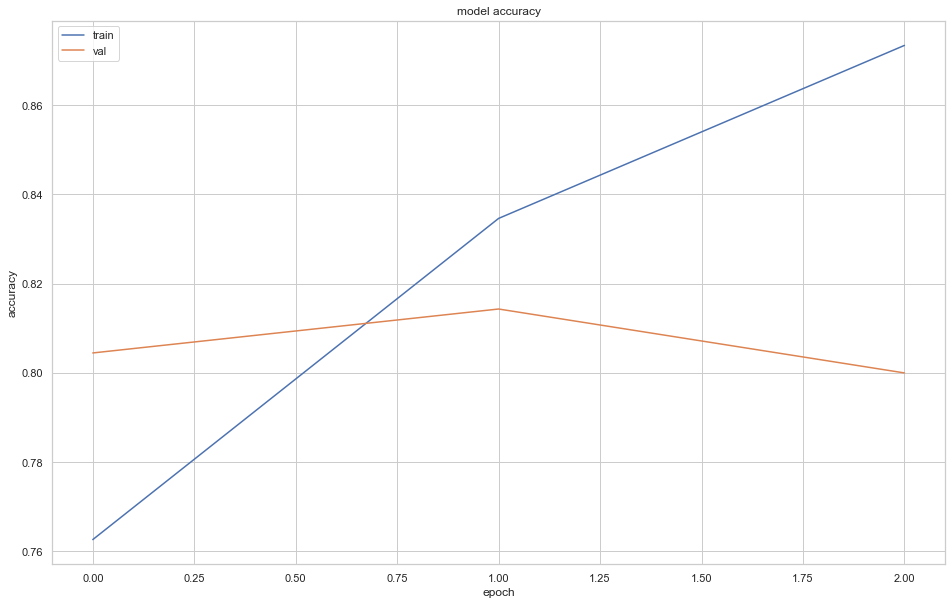

In [22]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

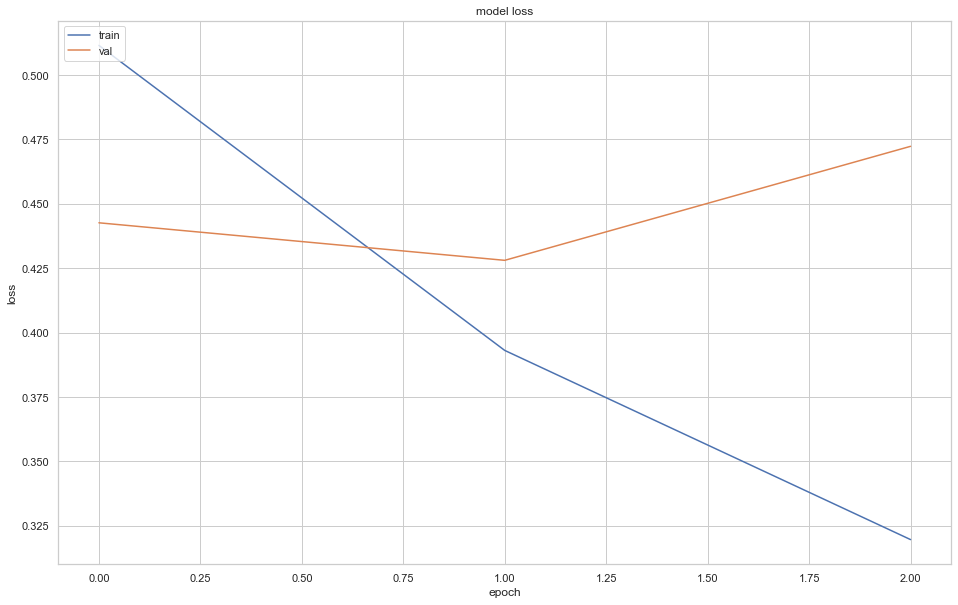

In [23]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
# predictions
test_pred = bert_model.predict(X_test)
print(test_pred)

TFSequenceClassifierOutput(loss=None, logits=array([[-0.1285194 ,  0.2899389 ],
       [-2.3529928 ,  2.2581232 ],
       [-2.1840599 ,  2.045693  ],
       ...,
       [-1.8980908 ,  1.8573881 ],
       [ 1.76792   , -1.408916  ],
       [-0.21499553,  0.33526152]], dtype=float32), hidden_states=None, attentions=None)


In [25]:
tensor_test_predictions = tf.math.softmax(test_pred.logits, axis=1)
print(tensor_test_predictions)

tf.Tensor(
[[0.39688572 0.6031143 ]
 [0.00984287 0.9901571 ]
 [0.01434715 0.9856528 ]
 ...
 [0.0228547  0.9771453 ]
 [0.95995325 0.04004679]
 [0.36580473 0.6341952 ]], shape=(2235, 2), dtype=float32)


In [26]:
test_predictions = [list(bert_model.config.id2label.keys())[i] for i in tf.math.argmax(tensor_test_predictions, axis=1).numpy()]

In [27]:
# model test function
def eval_model(predictions):
    print(accuracy_score(y_test, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_test), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_test, np.array(predictions), target_names=["not disaster", "disaster"]))

0.8


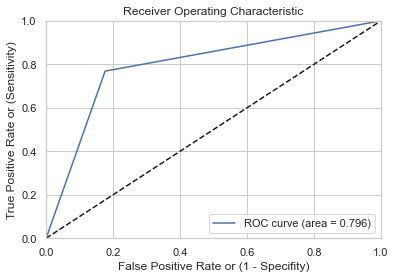

              precision    recall  f1-score   support

not disaster       0.82      0.82      0.82      1271
    disaster       0.77      0.77      0.77       964

    accuracy                           0.80      2235
   macro avg       0.80      0.80      0.80      2235
weighted avg       0.80      0.80      0.80      2235



In [28]:
eval_model(test_predictions)

In [29]:
# actual test predictions
real_pred = bert_model.predict(test_tokenised_text_df)
print(real_pred)

TFSequenceClassifierOutput(loss=None, logits=array([[-1.9080286 ,  1.8130229 ],
       [-0.6776087 ,  0.8346604 ],
       [-1.6416713 ,  1.6006675 ],
       ...,
       [-2.2559714 ,  2.0934513 ],
       [-1.4136682 ,  1.3852328 ],
       [-0.84401166,  0.9137889 ]], dtype=float32), hidden_states=None, attentions=None)


In [30]:
real_tensor_predictions = tf.math.softmax(real_pred.logits, axis=1)
print(real_tensor_predictions)

tf.Tensor(
[[0.0236363  0.97636366]
 [0.18060276 0.8193973 ]
 [0.03760316 0.96239686]
 ...
 [0.01274962 0.9872503 ]
 [0.05738359 0.9426164 ]
 [0.14706601 0.85293394]], shape=(3263, 2), dtype=float32)


In [31]:
# use argmax function to label
real_predictions = [list(bert_model.config.id2label.keys())[i] for i in tf.math.argmax(real_tensor_predictions, axis=1).numpy()]

### Preparing Kaggle Submission

All we need to do now is turn our output probabilities of our machine learning model into boolean values and submit the predictions!

In [32]:
utils.kaggle_submit(real_predictions, 'submission-heavy.csv')

To submit, we use the Kaggle API and type the following:

`kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"`